# RSNA Intracranial Hemorrhage Detection Challenge
---

Import Modules + Set up

In [2]:
!pip install Pillow
!pip install scikit-multilearn

from __future__ import print_function, division
import PIL
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, models, transforms
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import precision_score, f1_score, accuracy_score, hamming_loss, multilabel_confusion_matrix, classification_report
from sklearn.metrics.ranking import roc_auc_score

import time
import os
import copy
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 92kB 4.0MB/s 
Setup complete. Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [3]:
torch.manual_seed(1995)
torch.cuda.manual_seed(1995)
np.random.seed(1995)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_PATH='/content/drive/My Drive/Colab Notebooks/hemorrhage-data/'

In [6]:
plt.ion()

# Data Exploration

load the labels into dataframe with correct index

In [7]:
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv', index_col=0).reset_index().drop(columns='index')

In [8]:
train_labels

,ID,epidural,intraparenchymal,subarachnoid
0,train_0,1,0,1
1,train_1,1,0,0
2,train_2,1,0,1
3,train_3,1,0,1
4,train_4,1,0,0
...,...,...,...,...
8537,train_8588,0,0,0
8538,train_8589,0,0,0
8539,train_8590,0,0,0
8540,train_8591,0,0,0


check there are no missing data or NaNs

In [9]:
train_labels.count()

ID                  8542
epidural            8542
intraparenchymal    8542
subarachnoid        8542
dtype: int64

check the distribution of data for any imbalance

In [10]:
label_counts = train_labels[["epidural", "intraparenchymal", "subarachnoid"]].apply(pd.Series.value_counts)
label_counts

,epidural,intraparenchymal,subarachnoid
0,8201,5350,5584
1,341,3192,2958


Check the overall distribution between positive and negative labels - there are much more negative cases than positive cases, as is often the case with medical data

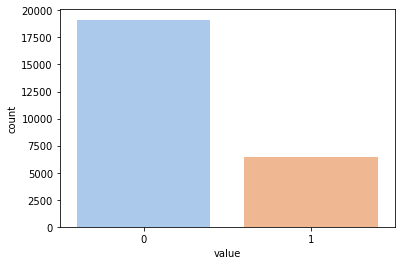

In [11]:
sns.countplot(data=pd.melt(train_labels[["epidural", "intraparenchymal","subarachnoid"]]),x='value', palette='pastel')

Check the distribution between classes - from here we can see epidural hemorrhages are underrepresented as they are much rarer than the other two

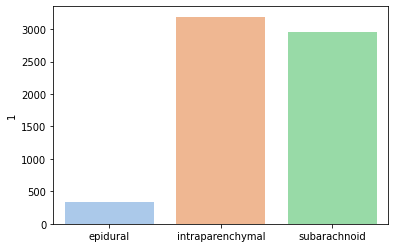

In [12]:
sns.barplot(x=label_counts.columns, y=label_counts.iloc[1], palette='pastel')

# Data Preprocessing

## Load data from directory

In [13]:
def load_data(root_dir, labels_df):

  data_len = len(labels_df)
  all_data = []
  all_labels = []
  
  print("loading data...")

  for idx in range(data_len):
    if idx % 100 == 0:
      print("loading index ", idx)

    img_name = root_dir + str(labels_df.loc[idx, 'ID']) + '.png'
    # print(img_name)
    image = Image.open(img_name)
    labels = np.array(labels_df.iloc[idx, 1:], dtype=float)

    all_data.append(image)
    all_labels.append(labels)

  return all_data, all_labels

In [14]:
all_data, all_labels = load_data(DATA_PATH + 'train_images/', train_labels)

loading data...
loading index  0
loading index  100
loading index  200
loading index  300
loading index  400
loading index  500
loading index  600
loading index  700
loading index  800
loading index  900
loading index  1000
loading index  1100
loading index  1200
loading index  1300
loading index  1400
loading index  1500
loading index  1600
loading index  1700
loading index  1800
loading index  1900
loading index  2000
loading index  2100
loading index  2200
loading index  2300
loading index  2400
loading index  2500
loading index  2600
loading index  2700
loading index  2800
loading index  2900
loading index  3000
loading index  3100
loading index  3200
loading index  3300
loading index  3400
loading index  3500
loading index  3600
loading index  3700
loading index  3800
loading index  3900
loading index  4000
loading index  4100
loading index  4200
loading index  4300
loading index  4400
loading index  4500
loading index  4600
loading index  4700
loading index  4800
loading index  4

In [15]:
assert len(all_data) == len(all_labels)

In [16]:
all_data = np.asarray(all_data, dtype=object)
all_labels = np.asarray(all_labels, dtype=float)

In [17]:
#reshape the data for next step
print(all_data.shape)
all_data = np.expand_dims(all_data, 1)
print(all_labels.shape)
print(all_data.shape)

(8542,)
(8542, 3)
(8542, 1)


## Splitting data into train / val / test

As we saw in # Data Exploration the dataset is highly imbalanced. Here we use iterative_train_test_split to split the data into training, validation, testing (70%, 15%, 15%), which stratifies the multi-label data in each fold ensuring a balanced proportion of each label combination is present.
(http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html#skmultilearn.model_selection.iterative_stratification.iterative_train_test_split)


In [18]:
X, y, test_data, test_labels = iterative_train_test_split(all_data, all_labels, test_size = 0.15)
tr_data, tr_labels, val_data, val_labels = iterative_train_test_split(X, y, test_size = 0.15)

Using a counter we can verify that the distribution in train/val folds are representative of actual distribution of data

In [19]:
from collections import Counter
Counter(str(e) for e in list(tr_labels))

Counter({'[0. 0. 0.]': 2494,
         '[0. 0. 1.]': 1202,
         '[0. 1. 0.]': 1360,
         '[0. 1. 1.]': 868,
         '[1. 0. 0.]': 138,
         '[1. 0. 1.]': 31,
         '[1. 1. 0.]': 42,
         '[1. 1. 1.]': 36})

In [21]:
Counter(str(e) for e in list(all_labels))

Counter({'[0. 0. 0.]': 3463,
         '[0. 0. 1.]': 1654,
         '[0. 1. 0.]': 1873,
         '[0. 1. 1.]': 1211,
         '[1. 0. 0.]': 180,
         '[1. 0. 1.]': 53,
         '[1. 1. 0.]': 68,
         '[1. 1. 1.]': 40})

In [22]:
# check numbers and shapes of our data
tr_data = np.squeeze(tr_data)
val_data = np.squeeze(val_data)
test_data = np.squeeze(test_data)

print("train_data shape: ", tr_data.shape)
print("train_labels shape: ", tr_labels.shape)
print("val_data shape: ", val_data.shape)
print("val_labels shape: ", val_labels.shape)
print("test_data shape: ", test_data.shape)
print("test_labels shape: ", test_labels.shape)

train_data shape:  (6171,)
train_labels shape:  (6171, 3)
val_data shape:  (1089,)
val_labels shape:  (1089, 3)
test_data shape:  (1282,)
test_labels shape:  (1282, 3)


## Define custom DataLoader
Here we define a custom Dataset class with transforms argument in Pytorch to load our stratify-split datasets.

In [120]:
class Dataset:

    def __init__(self, data, labels, transform=None, load_test=False):
      """
      Args:
          data (array): array containing all image objects
          labels (array): array containing all labels
          transforms (object, optional): optional transforms to be applied
          load_test (bool): load directly from folder for test set w/o labels
      """

      self.data = data
      self.labels = labels
      self.transform = transform
      self.load_test = load_test
      if load_test:
        self.img_names = [f for f in os.listdir(DATA_PATH + 'test_images/') 
        if not f.startswith('.')]

    def __len__(self):
      if self.load_test:
        return len(self.img_names)
      else:
        return len(self.labels)

    def __getitem__(self, idx):
        """ Here we return the item requested by `idx` and apply transforms
            The PyTorch DataLoader class will use this method to make an iterable 
            for our training or validation loop.
        """
        if torch.is_tensor(idx):
          idx = idx.tolist()

        if self.load_test:
          image = Image.open(DATA_PATH + 'test_images/' + self.img_names[idx]).convert('RGB')
          labels = self.img_names[idx]
        else:
          # convert greyscale image to 3 channels as pretrained models take colour images as input
          image = self.data[idx].convert('RGB') 
          labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        if self.transform is not None:
            image = self.transform(image)

        return image, labels

## Define data augmentations
Data augmentation is a common strategy to generate more training samples, prevent overfitting, and improve the generalization capabilities of deep networks, especially CNNs. Here we apply a few common transformations using the Pytorch transforms class - random rotation, flip, as well as jitters in contrast. We also resize the data to 224 x 224 as we are using a pretrained network.

In [24]:
# resizing, normalization, and data augmentations for training data
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.RandomRotation(180),
                                       transforms.ColorJitter(contrast=0),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# just resizing and normalization for validation data
val_transforms = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


train_ds = Dataset(tr_data, tr_labels, transform=train_transforms)
val_ds = Dataset(val_data, val_labels, transform=val_transforms)
test_ds = Dataset(test_data, test_labels, transform=val_transforms)

In [25]:
# sanity check
for i in range(len(train_ds)):
  sample = train_ds[i]
  print(sample[0].shape)
  print(sample[1].shape)

  if i == 3:
    break

torch.Size([3, 224, 224])
torch.Size([3])
torch.Size([3, 224, 224])
torch.Size([3])
torch.Size([3, 224, 224])
torch.Size([3])
torch.Size([3, 224, 224])
torch.Size([3])


To address the imbalanced dataset we also use the WeightedRandomSampler in Pytorch, which ensures the samples drawn in each batch are drawn according to the weights given.

In [26]:
def make_weights_for_balanced_classes(dataset, label_counts): 
    # get list of class labels and shuffle                       
    labels_list = torch.LongTensor(dataset.labels)
    labels_list = labels_list[torch.randperm(len(labels_list))]

    # get class counts and calculate weight by taking its reciprocal
    class_count = list(label_counts.iloc[1,:])
    class_weight = 1./torch.tensor(class_count, dtype=torch.float)

    # now assign weight of each class to all samples
    class_weights_all = class_weight[labels_list]

    return class_weights_all

In [27]:
# create a weighted sampler to ensure each class to sampled equally in batches
weights = make_weights_for_balanced_classes(train_ds, label_counts)
print(weights.shape)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

torch.Size([6171, 3])


Define the batch size and create dataloaders

In [56]:
batch_size = 32

class_names = ["epidural", "intraparenchymal", "subarachnoid"]

dataloaders = {"train": DataLoader(train_ds, shuffle=True, batch_size=batch_size),
               "val": DataLoader(val_ds, shuffle=True, batch_size=batch_size),
               "test": DataLoader(test_ds, shuffle=True, batch_size=batch_size)}

Visualise a batch of training data to make sure everything is working as expected

In [33]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

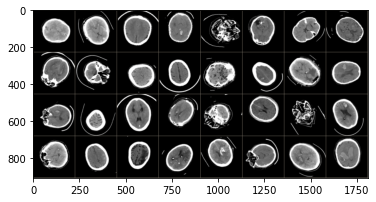

tensor([[0., 0., 1.],
        [0., 1., 1.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 1., 1.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 1.],
        [0., 1., 0.]])


In [36]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)
print(classes)

# Defining the Model

Here I define a baseline model, which is a simple CNN made of 4 sequential 2D convolutional blocks followed by two linear layers, and a ResNet50 pretrained network, which is used in a transfer learning approach.

## Baseline Model

In [37]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
              nn.init.zeros_(m.bias)
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [38]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

In [39]:
base_model=Classifier(3)

In [40]:
base_model

Classifier(
  (conv): Sequential(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  

## Pretrained ResNet50 model

To use ResNet50 for transfer learning we first download the pretrained model, then freeze the entire convolution base and create out own classifier head to replace at the end of the network. 

In [41]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the num of features in last linear unit
print(num_features)

# freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



2048


In [42]:
def create_layer(num_features, number_classes, dropout_prob=0.5, activation_func=nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

In [43]:
custom_classifier = create_layer(num_features , len(class_names)) # create a custom fc layer
model.fc = custom_classifier # replace the fully connected layer with our custom layer

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

Function with main training loop

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs,labels)
                    preds = torch.sigmoid(outputs).data > 0.5
                    preds = preds.to(torch.float32)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += f1_score(labels.to("cpu").to(torch.int).numpy(),
                                             preds.to("cpu").to(torch.int).numpy(), average="samples")  * inputs.size(0)

                cm = multilabel_confusion_matrix(labels.to("cpu").to(torch.int).numpy(),
                                      preds.to("cpu").to(torch.int).numpy())
                # if phase == 'train':
                #   print("train cm")
                # else:
                #   print("val cm")
                # print(cm)

            if phase == 'train':
              scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, DATA_PATH + 'best_weight.pt')
            
            if phase == 'train':
              train_acc.append(epoch_acc)
              train_loss.append(epoch_loss)
            else:
              val_acc.append(epoch_acc)
              val_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_acc, train_loss, val_acc, val_loss

## Defining training parameters

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# send models to GPU
base_mode = base_model.to(device)
model = model.to(device)

# weight calculated negative/positive samples in each class to balance
pos_weight = torch.FloatTensor([8201/341, 5350/3192, 5584/2958]).cuda() 
criterion = nn.BCEWithLogitsLoss()#pos_weight=pos_weight)  #multi-label multi-class binary loss function

# defining optimizer and learning rate scheduler
optimizer = optim.SGD(model.fc.parameters(), lr = 0.001, momentum=0.9)
lr = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
# lr = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005)

In [50]:
base_model, base_train_acc, base_train_loss, base_val_acc, base_val_loss = train_model(
    base_model, criterion, optimizer, lr, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.7452 Acc: 0.2228
val Loss: 0.6976 Acc: 0.1832

Epoch 1/49
----------
train Loss: 0.7475 Acc: 0.2250
val Loss: 0.6931 Acc: 0.2158

Epoch 2/49
----------
train Loss: 0.7463 Acc: 0.2187
val Loss: 0.6977 Acc: 0.1788

Epoch 3/49
----------
train Loss: 0.7426 Acc: 0.2238
val Loss: 0.6929 Acc: 0.1936

Epoch 4/49
----------
train Loss: 0.7428 Acc: 0.2298
val Loss: 0.6908 Acc: 0.1687

Epoch 5/49
----------
train Loss: 0.7465 Acc: 0.2214
val Loss: 0.7023 Acc: 0.2323

Epoch 6/49
----------
train Loss: 0.7443 Acc: 0.2205
val Loss: 0.6988 Acc: 0.2119

Epoch 7/49
----------
train Loss: 0.7452 Acc: 0.2246
val Loss: 0.6893 Acc: 0.2159

Epoch 8/49
----------
train Loss: 0.7432 Acc: 0.2248
val Loss: 0.6975 Acc: 0.2109

Epoch 9/49
----------
train Loss: 0.7454 Acc: 0.2194
val Loss: 0.6938 Acc: 0.1745

Epoch 10/49
----------
train Loss: 0.7461 Acc: 0.2203
val Loss: 0.6988 Acc: 0.2184

Epoch 11/49
----------
train Loss: 0.7450 Acc: 0.2243
val Loss: 0.6970 Acc: 0.1989

Ep

In [48]:
model, train_acc, train_loss, val_acc, val_loss = train_model(
    model, criterion, optimizer, lr, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6563 Acc: 0.2980
val Loss: 0.5788 Acc: 0.3033

Epoch 1/19
----------
train Loss: 0.5818 Acc: 0.3121
val Loss: 0.5485 Acc: 0.3272

Epoch 2/19
----------
train Loss: 0.5372 Acc: 0.3159
val Loss: 0.5015 Acc: 0.2806

Epoch 3/19
----------
train Loss: 0.5140 Acc: 0.3098
val Loss: 0.4852 Acc: 0.3028

Epoch 4/19
----------
train Loss: 0.4885 Acc: 0.3050
val Loss: 0.4670 Acc: 0.2509

Epoch 5/19
----------
train Loss: 0.4797 Acc: 0.3059
val Loss: 0.4651 Acc: 0.2616

Epoch 6/19
----------
train Loss: 0.4783 Acc: 0.2995
val Loss: 0.4691 Acc: 0.2786

Epoch 7/19
----------
train Loss: 0.4757 Acc: 0.3079
val Loss: 0.4618 Acc: 0.2500

Epoch 8/19
----------
train Loss: 0.4734 Acc: 0.2996
val Loss: 0.4643 Acc: 0.2739

Epoch 9/19
----------
train Loss: 0.4730 Acc: 0.2959
val Loss: 0.4638 Acc: 0.2633

Epoch 10/19
----------
train Loss: 0.4705 Acc: 0.3025
val Loss: 0.4607 Acc: 0.2646

Epoch 11/19
----------
train Loss: 0.4744 Acc: 0.3009
val Loss: 0.4610 Acc: 0.2612

Ep

# Evaluation

## Training & Validation Loss

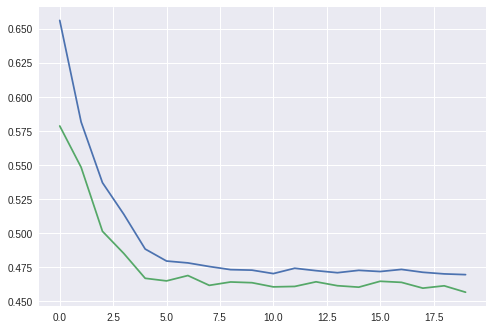

In [49]:
plt.style.use("seaborn")
plt.plot(train_loss)
plt.plot(val_loss)

## Final validation on test set

In [95]:
def computeAUROC(labels, preds, classCount):

    AUROC = []
    #labels = labels.view(-1, 3).contiguous().cuda()
    preds = preds.cpu().numpy()

    for i in range(classCount):
      if len(np.unique(labels[:, i])) == 2:
        AUROC.append(roc_auc_score(labels[:, i], preds[:, i]))

    return AUROC

In [77]:
def plot_confusion_matrix(cm):

  df_cm = pd.DataFrame(cm, range(2), range(2))
  # plt.figure(figsize=(10,7))
  sns.set(font_scale=1.4) 

  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})

  plt.show()

function to get final F1 accuracy and other stats on the test set

In [100]:
# Validation on the test set
def test(model, dataloaders, device):

  model.eval()
  accuracy = 0
  cm = np.zeros([3,2,2])
  
  model.to(device)
    
  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)
      
    output = model.forward(images)
    preds = torch.sigmoid(output).data > 0.5

    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    accuracy += f1_score(labels, preds, average="samples")
    cm = cm.__add__(multilabel_confusion_matrix(labels, preds))
    
    auc = computeAUROC(labels, torch.sigmoid(output).data, 3)

  print("Final testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))
  print("AUC:", auc)
  print(classification_report(labels, preds))
  print(cm)

In [101]:
test(model, dataloaders, device)

Final testing Accuracy: 0.342
AUC: [1.0]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         1
   macro avg       0.33      0.33      0.33         1
weighted avg       1.00      1.00      1.00         1
 samples avg       0.50      0.50      0.50         1

[[[1222.    9.]
  [  50.    1.]]

 [[ 558.  245.]
  [ 123.  356.]]

 [[ 503.  335.]
  [ 122.  322.]]]


# Prediction

Function for predictions

In [126]:
def predict(model, batch_size=32):

    pred_test_ds = Dataset(data=None, labels=None, transform=val_transforms, load_test=True)
    test_loader = DataLoader(pred_test_ds, batch_size=batch_size, shuffle=False)

    was_training = model.training
    model.cuda()
    model.eval()

    prob_outputs, pred_outputs, all_filenames = [], [], []

    with torch.no_grad():
      for image, filename in test_loader:
        image = image.to(device)
        probs = torch.sigmoid(model(image))
        preds = probs.data > 0.5

        prob_outputs.append(probs.cpu().numpy())
        pred_outputs.append(preds.cpu().numpy())
        all_filenames.extend(filename)
        # print(filename)
      
      test_probs = pd.DataFrame(data=np.concatenate(prob_outputs),
                                index=all_filenames,
                                columns=class_names)
      test_preds = pd.DataFrame(data=np.concatenate(pred_outputs),
                                index=all_filenames,
                                columns=class_names)

    return test_probs, test_preds

In [127]:
test_probs, test_preds = predict(model)

Some formatting and reindexing before saving to csv

In [148]:
test_probs.index = test_probs.index.str.strip('.png')
test_preds.index = test_preds.index.str.strip('.png')

test_probs = test_probs.reindex(index=test_probs.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)
test_preds = test_preds.reindex(index=test_preds.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)

In [158]:
test_preds = test_preds.astype(int)

In [160]:
test_probs.to_csv(DATA_PATH + "probs_predictions.csv")
test_preds.to_csv(DATA_PATH + "binary_predictions.csv")